<a href="https://colab.research.google.com/github/krupaanand312jc/EMG_Hand_Movements_NN/blob/main/EMG_Hand_Movements_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EMG based Classification of Basic Hand Movements using CNN



## Clone the Repository containing the Single Channel sEMG Data from GitHub
Reference for the sEMG Database: C. Sapsanis, Recognition of Basic Hand Movements Using Electromyography, Diploma Thesis, University of Patras, 2013


In [ ]:
! git clone https://github.com/krupaanand312jc/EMG_Hand_Movements_NN

Cloning into 'EMG_Hand_Movements_NN'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 60 (delta 24), reused 31 (delta 4), pack-reused 0
Unpacking objects: 100% (60/60), done.


## Import the required packages

In [ ]:
import numpy as np
import scipy
from scipy import io
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tempfile
import os

from matplotlib import cm


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, utils

## Load the dataset from the directory
The Dataset consists 'two' single channel sEMG data collected and filtered  from one healthy male person for 3 consecutive days.
First Channel data is from the muscle 'Flexor Capri Ulnaris' and
Second Channel data is from the muscle 'Extensor Capri Radialis'

In [ ]:
data1 = io.loadmat('/content/EMG_Hand_Movements_NN/Dataset/Database 2/male_day_1.mat')
data2 = io.loadmat('/content/EMG_Hand_Movements_NN/Dataset/Database 2/male_day_2.mat')
data3 = io.loadmat('/content/EMG_Hand_Movements_NN/Dataset/Database 2/male_day_3.mat')

## Preparing the Dataset for training the Neural Network

### Prepare the Data ready for splitting
Our Data contains EMG Signal data containing 6 classes collected from  two single channels for 3 days 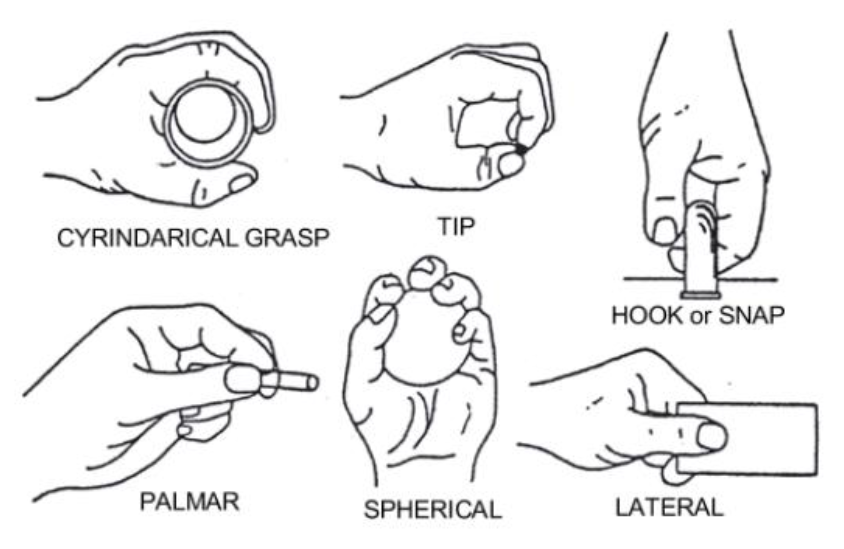

#### Prepare the Label set

In [ ]:
# Fixed params
n_classes = 6
n_channels = 1

split_type = 'train'

train_days = [1, 2, 3]
test_days = [1, 2, 3]

if split_type == 'train':
        split = train_days
else:
        split = test_days

# Assign numeric label to categories:
#
# cyl = 1
# hook = 2
# lat = 3
# palm = 4
# spher = 5
# tip = 6
#

labels = np.concatenate(
        (
            [[class_id for _ in range(100 * len(split))] for class_id in range(1, n_classes+1)]
        )
    )

#### Prepare the Data set

##### Assign the respective variables for the respective classes and days
**NOTE:** Since our project is based on single channel sEMG Signals, please use the Data from any one channel. 

In [ ]:
# Uncomment this for Channel 1

cyl_day1 = data1['cyl_ch1']
hook_day1 = data1['hook_ch1']
tip_day1 = data1['tip_ch1']
palm_day1 = data1['palm_ch1']
spher_day1 = data1['spher_ch1']
lat_day1 = data1['lat_ch1']

cyl_day2 = data2['cyl_ch1']
hook_day2 = data2['hook_ch1']
tip_day2 = data2['tip_ch1']
palm_day2 = data2['palm_ch1']
spher_day2 = data2['spher_ch1']
lat_day2 = data2['lat_ch1']

cyl_day3 = data3['cyl_ch1']
hook_day3 = data3['hook_ch1']
tip_day3 = data3['tip_ch1']
palm_day3 = data3['palm_ch1']
spher_day3 = data3['spher_ch1']
lat_day3 = data3['lat_ch1']

# Uncomment this for Channel 2

# cyl_day1 = data1['cyl_ch2']
# hook_day1 = data1['hook_ch2']
# tip_day1 = data1['tip_ch2']
# palm_day1 = data1['palm_ch2']
# spher_day1 = data1['spher_ch2']
# lat_day1 = data1['lat_ch2']

# cyl_day2 = data2['cyl_ch2']
# hook_day2 = data2['hook_ch2']
# tip_day2 = data2['tip_ch2']
# palm_day2 = data2['palm_ch2']
# spher_day2 = data2['spher_ch2']
# lat_day2 = data2['lat_ch2']

# cyl_day3 = data3['cyl_ch2']
# hook_day3 = data3['hook_ch2']
# tip_day3 = data3['tip_ch2']
# palm_day3 = data3['palm_ch2']
# spher_day3 = data3['spher_ch2']
# lat_day3 = data3['lat_ch2']

##### Stack all the data into a single set according to the classes

In [ ]:
X = np.vstack([cyl_day1, cyl_day2, cyl_day3,
               hook_day1, hook_day2, hook_day3,
               lat_day1, lat_day2, lat_day3,
               palm_day1, palm_day2, palm_day3,
               spher_day1, spher_day2, spher_day3,
               tip_day1, tip_day2, tip_day3])

# Drop last 4 data points to more easily subdivide into layers
X = np.delete(X, [2496, 2497, 2498, 2499], 1)

In [ ]:
X = X.reshape(1800, 2496, 1)

### Split the Data (X and labels) into Train and Test sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.4, random_state=42)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape) 

(810, 2496, 1)
(270, 2496, 1)
(720, 2496, 1)


In [ ]:
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(810,)
(270,)
(720,)


### One-hot encode the labels in train, validation and test sets

In [ ]:
# y_train = tf.keras.utils.to_categorical(y_train, num_classes=n_classes, dtype='float32')
# y_val = tf.keras.utils.to_categorical(y_val, num_classes=n_classes, dtype='float32')
# y_test = tf.keras.utils.to_categorical(y_test, num_classes=n_classes, dtype='float32')
def one_hot(labels, n_class=6):
    """
    One-hot encoding.
    :param labels: Labels to encode.
    :param n_class: Number of classes.
    :return: One-hot encoded labels.
    """
    expansion = np.eye(n_class)
    y = expansion[:, labels-1].T

    assert y.shape[1] == n_class, "Wrong number of labels!"

    return y

y_train = one_hot(y_train)
y_val = one_hot(y_val)
y_test = one_hot(y_test)

In [ ]:
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(810, 6)
(270, 6)
(720, 6)


## Training the Neural Network

In [ ]:
# The following were determined through iterative trial and error:
batch_size = 100
seq_len = 2496
learning_rate = 0.00001
epochs = 2500

# Fixed params
n_classes = 6
n_channels = 1

In [ ]:
!pip install -q tensorflow-model-optimization

     |████████████████████████████████| 211 kB 4.0 MB/s 


### Prepare the Model for training

In [ ]:
model = keras.models.Sequential([
  # keras.layers.InputLayer(input_shape=(seq_len, n_channels)),

  # keras.layers.BatchNormalization(),           

  # keras.layers.(target_shape=(seq_len, n_channels)),

  # (batch, 2496, 1) --> (batch, 1248, 2)
  keras.layers.Conv1D(filters=2, kernel_size=1, strides=1, padding='same', activation = 'relu', input_shape=(2496,1)),
  tf.keras.layers.MaxPool1D(pool_size=2, strides=2, padding='same'),

  # (batch, 1248, 2) --> (batch, 624, 4)
  tf.keras.layers.Conv1D(filters=4, kernel_size=1, strides=1, padding='same', activation = 'relu'),
  tf.keras.layers.MaxPool1D(pool_size=2, strides=2, padding='same'),

  # (batch, 624, 4) --> (batch, 312, 8)
  tf.keras.layers.Conv1D(filters=8, kernel_size=1, strides=1, padding='same', activation = 'relu'),
  tf.keras.layers.MaxPool1D(pool_size=2, strides=2, padding='same'),

  # (batch, 312, 8) --> (batch, 156, 16)
  tf.keras.layers.Conv1D(filters=16, kernel_size=1, strides=1, padding='same', activation = 'relu'),
  tf.keras.layers.MaxPool1D(pool_size=2, strides=2, padding='same'),

  # (batch, 156, 16) --> (batch, 78, 32)
  tf.keras.layers.Conv1D(filters=32, kernel_size=1, strides=1, padding='same', activation = 'relu'),
  tf.keras.layers.MaxPool1D(pool_size=2, strides=2, padding='same'),

  # (batch, 78, 32) --> (batch, 39, 64)
  tf.keras.layers.Conv1D(filters=64, kernel_size=1, strides=1, padding='same', activation = 'relu'),
  tf.keras.layers.MaxPool1D(pool_size=2, strides=2, padding='same'),

  tf.keras.layers.Flatten(),

  tf.keras.layers.Dense(156, activation='relu'),

  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Dense(18, activation='relu'),

  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Dense(n_classes, activation='softmax')

]) 

In [ ]:
import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

end_step = np.ceil(X_train.shape[0] / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}

model = prune_low_magnitude(model, **pruning_params)

/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py:2223: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


In [ ]:
model.compile(tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Model Summary

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prune_low_magnitude_conv1d ( (None, 2496, 2)           8         
_________________________________________________________________
prune_low_magnitude_max_pool (None, 1248, 2)           1         
_________________________________________________________________
prune_low_magnitude_conv1d_1 (None, 1248, 4)           22        
_________________________________________________________________
prune_low_magnitude_max_pool (None, 624, 4)            1         
_________________________________________________________________
prune_low_magnitude_conv1d_2 (None, 624, 8)            74        
_________________________________________________________________
prune_low_magnitude_max_pool (None, 312, 8)            1         
_________________________________________________________________
prune_low_magnitude_conv1d_3 (None, 312, 16)           2

### Train the model

In [ ]:
logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]
  
history = model.fit(X_train, y_train,
                  batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val),
                  callbacks=callbacks)

Streaming output truncated to the last 5000 lines.
9/9 [==============================] - 37s 215ms/step - loss: 1.7788 - accuracy: 0.1642 - val_loss: 1.7769 - val_accuracy: 0.1407
Epoch 2/2500
9/9 [==============================] - 0s 23ms/step - loss: 1.7706 - accuracy: 0.1877 - val_loss: 1.7726 - val_accuracy: 0.1407
Epoch 3/2500
9/9 [==============================] - 0s 25ms/step - loss: 1.7662 - accuracy: 0.1765 - val_loss: 1.7685 - val_accuracy: 0.1407
Epoch 4/2500
9/9 [==============================] - 0s 23ms/step - loss: 1.7622 - accuracy: 0.1815 - val_loss: 1.7646 - val_accuracy: 0.1407
Epoch 5/2500
9/9 [==============================] - 0s 23ms/step - loss: 1.7594 - accuracy: 0.1765 - val_loss: 1.7610 - val_accuracy: 0.1407
Epoch 6/2500
9/9 [==============================] - 0s 22ms/step - loss: 1.7546 - accuracy: 0.1926 - val_loss: 1.7574 - val_accuracy: 0.1481
Epoch 7/2500
9/9 [==============================] - 0s 24ms/step - loss: 1.7521 - accuracy: 0.2000 - val_loss: 1.7

### Evaluate the Model

In [ ]:
model.evaluate(X_test, y_test, batch_size=batch_size)

8/8 [==============================] - 0s 22ms/step - loss: 0.9626 - accuracy: 0.6778


[0.9626043438911438, 0.6777777671813965]

In [ ]:
model.metrics_names

['loss', 'accuracy']

### Plot the Train and Validation Losses and Accuracies

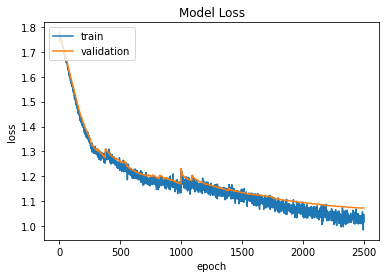

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

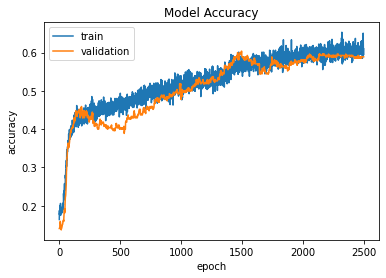

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)

### Confusion Matrix

In [ ]:
#importing confusion matrix
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, y_pred)
print('\033[1m'+'Confusion Matrix\n')
print('\033[0m')
print(confusion)

Confusion Matrix


[[ 51  12  13  13  16   8]
 [ 15 106   1   6   0   8]
 [ 18   4  52  21   5  14]
 [ 12   3  10  56   2  25]
 [  5   0   1   0 131   2]
 [  3   2   3  10   0  92]]


### Analyse various Metrics for each of the 6 classes

In [ ]:
#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

from sklearn.metrics import classification_report
print('\033[1m' + '\nClassification Report\n')
print('\033[0m' + classification_report(y_test, y_pred, target_names=['Cylindrical', 'Hook', 'Lateral', 'Palmer', 'Spherical', 'tip']))


Accuracy: 0.68

Micro Precision: 0.68
Micro Recall: 0.68
Micro F1-score: 0.68

Macro Precision: 0.66
Macro Recall: 0.66
Macro F1-score: 0.66

Weighted Precision: 0.68
Weighted Recall: 0.68
Weighted F1-score: 0.67

Classification Report

              precision    recall  f1-score   support

 Cylindrical       0.49      0.45      0.47       113
        Hook       0.83      0.78      0.81       136
     Lateral       0.65      0.46      0.54       114
      Palmer       0.53      0.52      0.52       108
   Spherical       0.85      0.94      0.89       139
         tip       0.62      0.84      0.71       110

    accuracy                           0.68       720
   macro avg       0.66      0.66      0.66       720
weighted avg       0.68      0.68      0.67       720



In [29]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model)

_, pruned_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)
print('Saved pruned Keras model to:', pruned_keras_file)

Saved pruned Keras model to: /tmp/tmp9jogotv9.h5


In [30]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
pruned_tflite_model = converter.convert()

_, pruned_tflite_file = tempfile.mkstemp('.tflite')

with open(pruned_tflite_file, 'wb') as f:
  f.write(pruned_tflite_model)

print('Saved pruned TFLite model to:', pruned_tflite_file)

INFO:tensorflow:Assets written to: /tmp/tmpkq2qy9cr/assets
Saved pruned TFLite model to: /tmp/tmpjqxes4n0.tflite


In [31]:
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)

In [32]:
print("Size of gzipped pruned Keras model: %.2f bytes" % (get_gzipped_model_size(pruned_keras_file)))
print("Size of gzipped pruned TFlite model: %.2f bytes" % (get_gzipped_model_size(pruned_tflite_file)))

Size of gzipped pruned Keras model: 467593.00 bytes
Size of gzipped pruned TFlite model: 441748.00 bytes


In [33]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_and_pruned_tflite_model = converter.convert()

_, quantized_and_pruned_tflite_file = tempfile.mkstemp('.tflite')

with open(quantized_and_pruned_tflite_file, 'wb') as f:
  f.write(quantized_and_pruned_tflite_model)

print('Saved quantized and pruned TFLite model to:', quantized_and_pruned_tflite_file)

# print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(keras_file)))
print("Size of gzipped pruned and quantized TFlite model: %.2f bytes" % (get_gzipped_model_size(quantized_and_pruned_tflite_file)))

INFO:tensorflow:Assets written to: /tmp/tmphrwp99kc/assets


INFO:tensorflow:Assets written to: /tmp/tmphrwp99kc/assets


Saved quantized and pruned TFLite model to: /tmp/tmp6md3ijxg.tflite
Size of gzipped pruned and quantized TFlite model: 134438.00 bytes


## Generate the TensorFlow Lite for Microcontrollers Model
To convert the TensorFlow Lite quantized model into a C source file that can be loaded by TensorFlow Lite for Microcontrollers on Arduino we need to use the ```xxd``` tool to convert the ```.tflite``` file into a ```.cc``` file.

In [34]:
!apt-get update && apt-get -qq install xxd

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:14 http://security.ubuntu.com/ubuntu bionic-security/restricted amd64 Packages [543

In [37]:
MODEL_TFLITE = quantized_and_pruned_tflite_file
MODEL_TFLITE_MICRO = 'EMG_NN.cc'
!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

Run the cell below to print out its contents which we'll need for our next step, deploying the model using the Arudino IDE!

In [38]:
!cat {MODEL_TFLITE_MICRO}

Streaming output truncated to the last 5000 lines.
  0x00, 0x00, 0x27, 0x00, 0x00, 0x00, 0x00, 0xde, 0x00, 0x00, 0x00, 0x00,
  0x00, 0x00, 0x00, 0x00, 0x1f, 0x00, 0x2c, 0x00, 0x00, 0x00, 0xe1, 0x00,
  0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x21,
  0x00, 0xde, 0x00, 0x00, 0x00, 0x00, 0x00, 0x36, 0x00, 0x00, 0x29, 0x00,
  0x00, 0x00, 0x00, 0x00, 0x00, 0xdd, 0x00, 0x00, 0x00, 0x00, 0x2a, 0x00,
  0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x21, 0x00, 0x00, 0x00, 0x00,
  0x1e, 0x2a, 0x00, 0x00, 0x00, 0x00, 0x31, 0x00, 0xdd, 0x00, 0x00, 0x00,
  0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x26, 0x00, 0x00, 0x00, 0x1c, 0x00,
  0xe1, 0x00, 0x00, 0x00, 0x00, 0x00, 0x33, 0x1c, 0x00, 0x00, 0x00, 0x00,
  0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x31, 0xde, 0x00, 0x00, 0x00, 0x00,
  0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0xdf, 0x00, 0x00, 0x2c, 0x00,
  0x00, 0x00, 0x1d, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00,
  0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0xdd, 0x2f, 0x00, 0x32,